In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import os
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

train_data = pd.read_csv("../data/raw/train_data_raw.csv")
test_data = pd.read_csv("../data/raw/test_data_raw.csv")

### Feature Engineering

In [2]:
# Calculating Transaction Amount and Income Ratio
train_data['Transaction_Income_Ratio'] = train_data['TransactionAmount_Amount'] / train_data['Income_Amount']
test_data['Transaction_Income_Ratio'] = test_data['TransactionAmount_Amount'] / test_data['Income_Amount']

# Handle division by zero if needed (e.g., replace infinity with NaN)
train_data['Transaction_Income_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
test_data['Transaction_Income_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

/tmp/ipykernel_11735/2877031898.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Transaction_Income_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_11735/2877031898.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

### Rudementary Feature Selection

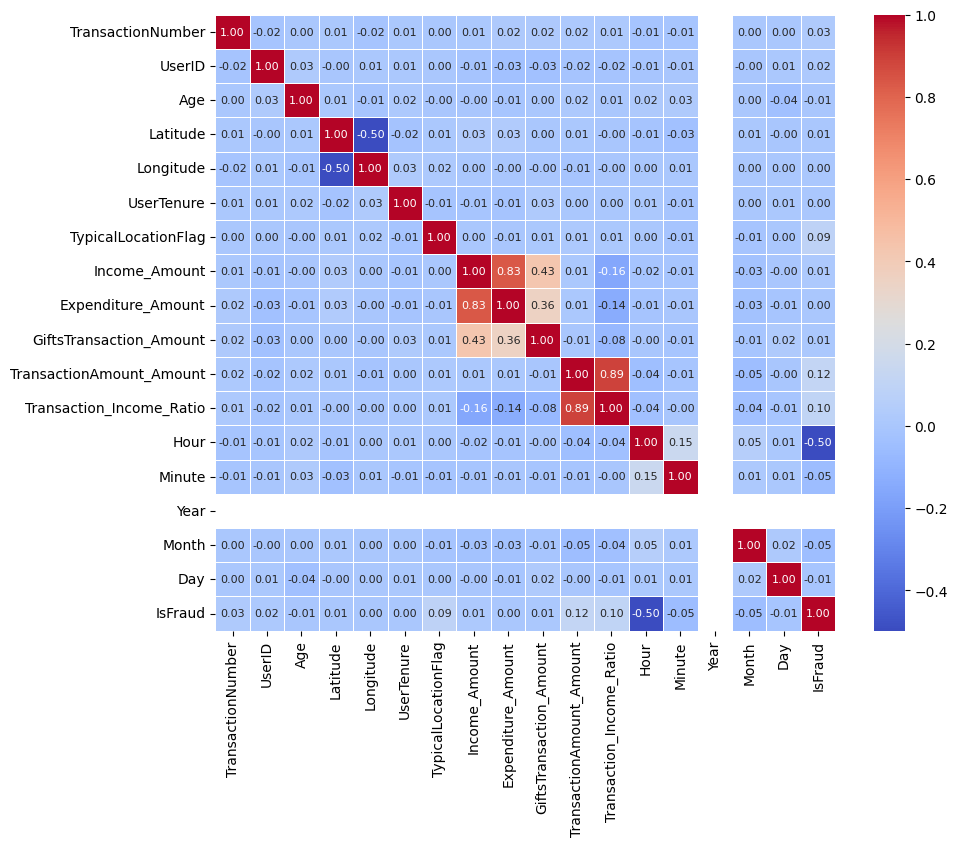

In [3]:
# Making a heatmap to show numerical Correlations
numerical_train_data = train_data[["TransactionNumber", "UserID", "Age", 
                                   "Latitude", "Longitude", "UserTenure",
                                   "TypicalLocationFlag",
                                   "Income_Amount", "Expenditure_Amount",
                                   "GiftsTransaction_Amount", "TransactionAmount_Amount",
                                   "Transaction_Income_Ratio", "Hour",
                                   "Minute", "Year", "Month", "Day", "IsFraud"]]


corr_train_matrix = numerical_train_data.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_train_matrix, annot=True, cmap="coolwarm", fmt=".2f", 
            linewidths=0.5, annot_kws={"size": 8})

# Creating folder if folder does not exist
folder_path = '../plots'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Saving file
file_path = os.path.join(folder_path, 'snsheatmap.png')
plt.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

In [4]:
# Checking the unique merchant counts in train data
unique_merchant_counts = train_data\
                         .groupby('TransactionLocation')\
                         ['MerchantID']\
                         .nunique()\
                         .reset_index(name='UniqueMerchantCount')

print(unique_merchant_counts)

  TransactionLocation  UniqueMerchantCount
0            Adelaide                    8
1            Brisbane                    8
2            Canberra                    8
3              Darwin                    8
4              Hobart                    8
5           Melbourne                    8
6               Perth                    8
7              Sydney                    8


In [5]:
# Making Domain column
train_data['Domain'] = train_data['EmailDomain'].apply(lambda email: email.split('@')[1] if pd.notnull(email) else '')
test_data['Domain'] = test_data['EmailDomain'].apply(lambda email: email.split('@')[1] if pd.notnull(email) else '')

train_data = train_data.drop(columns=['EmailDomain'])
test_data = test_data.drop(columns=['EmailDomain'])

In [6]:
data_to_note = ["Gender", "Occupation", "EducationLevel", 
                "MaritalStatus", "NumDependents", "Domain", 
                "MerchantID", "TransactionType", "Terrorism",
                "TransactionLocation", "DeviceType"]

# This function takes in a dataframe and a column name
def proportion(df, column):
    """
    This function finds the unique values in a column, the 
    fradulent proportions for each unique value, and the chi_square
    """
    df_fraud_proportion = df.groupby(column).agg(
        total_transactions=('IsFraud', 'size'),
        fraud_transactions=('IsFraud', 'sum')
    ).reset_index()

    # Calculating chi-square to test significance
    le = LabelEncoder()
    X_encoded = le.fit_transform(df[column])
    chi_square = chi2(X_encoded.reshape(-1, 1), df['IsFraud'])
    p_score = chi_square[1]

    df_fraud_proportion['fraud_proportion'] = df_fraud_proportion['fraud_transactions'] / df_fraud_proportion['total_transactions']
    print(f"{column}: Unique Values: {df[column].nunique()}")
    print(f"Chi_Square:{chi_square[0]}, p-score:{p_score}")
    print(tabulate(df_fraud_proportion, headers='keys', tablefmt='grid'))
    print()

    # Columns with a p-score more than 0.05 are deemed insignificant to the model
    if p_score[0] > 0.05:
        return [column, p_score]
    else:
        return [None, p_score]

useless_features = []
p_score_table = {"features":[], "p_score":[]}

for item in data_to_note:
    insignificant_feature = proportion(train_data, item)
    p_score_table["features"].append(item)
    p_score_table["p_score"].append(insignificant_feature[1])
    if insignificant_feature[0]:
        useless_features.append(insignificant_feature[0])

Gender: Unique Values: 9
Chi_Square:[0.5085122], p-score:[0.47578362]
+----+-------------+----------------------+----------------------+--------------------+
|    | Gender      |   total_transactions |   fraud_transactions |   fraud_proportion |
+====+=============+======================+======================+====================+
|  0 | Female      |                 4426 |                 1610 |           0.36376  |
+----+-------------+----------------------+----------------------+--------------------+
|  1 | Male        |                 4887 |                 1790 |           0.366278 |
+----+-------------+----------------------+----------------------+--------------------+
|  2 | fem         |                  220 |                   78 |           0.354545 |
+----+-------------+----------------------+----------------------+--------------------+
|  3 | he          |                  268 |                  101 |           0.376866 |
+----+-------------+----------------------+-------

In [7]:
pd.DataFrame(p_score_table)

,features,p_score
0,Gender,[0.47578362428188414]
1,Occupation,[0.07749664283086621]
2,EducationLevel,[0.35621291135461486]
3,MaritalStatus,[0.30206010232407565]
4,NumDependents,[0.004375701664816187]
5,Domain,[0.1424099614935462]
6,MerchantID,[0.9953974123291871]
7,TransactionType,[1.2261551379992349e-277]
8,Terrorism,[0.23393650717730846]
9,TransactionLocation,[4.780041589495262e-15]


In [8]:
# Analyzing if any combination of transaction type and location suggests fraudulent
# Checking for any difference between the proportion of fraud in all situations
df_fraud_proportion = train_data.groupby(['TransactionType', 'TransactionLocation']).agg(
    total_transactions=('IsFraud', 'size'),
    fraud_transactions=('IsFraud', 'sum')
).reset_index()

# Calculate the proportion of fraud transactions (IsFraud = 1)
df_fraud_proportion['fraud_proportion'] = df_fraud_proportion['fraud_transactions'] / df_fraud_proportion['total_transactions']

# Print the resulting DataFrame
df_fraud_proportion

,TransactionType,TransactionLocation,total_transactions,fraud_transactions,fraud_proportion
0,Payment,Adelaide,134,31,0.231343
1,Payment,Brisbane,144,43,0.298611
2,Payment,Canberra,132,37,0.280303
3,Payment,Darwin,130,37,0.284615
4,Payment,Hobart,156,38,0.243590
5,Payment,Melbourne,139,0,0.000000
6,Payment,Perth,149,40,0.268456
7,Payment,Sydney,139,33,0.237410
8,Purchase,Adelaide,681,184,0.270191
9,Purchase,Brisbane,669,170,0.254111


In [9]:
# All features deemed to have not much significance
useless_features

['Gender',
 'Occupation',
 'EducationLevel',
 'MaritalStatus',
 'Domain',
 'MerchantID',
 'Terrorism',
 'DeviceType']

In [10]:
# Removing Useless Features
train_data = train_data.drop(columns=useless_features)
test_data= test_data.drop(columns=useless_features)

### Saving to /data/currated

In [11]:
import os

# Creating folder if folder does not exist
folder_path = '../data/curated'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Saving to /data/curated
train_file_path = os.path.join(folder_path, 'train_data_curated.csv')
test_file_path = os.path.join(folder_path, 'test_data_curated.csv')

train_data.to_csv(train_file_path, index=False)
test_data.to_csv(test_file_path, index=False)